<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">1. Camera calibration</p>

In this part we will work with the image sequence of the ``left`` directory. This sequence contains a series of images of the calibration template. For the calibration it should be taken into account that the size of each template slot is 30 mm in the $X$ and $Y$ axis.

In [2]:
import cv2
import glob
import copy
import math
import numpy as np
import imageio
import matplotlib.pyplot as plt

from pprint import pprint as pp

In [3]:
def load_images(filenames):
    return [imageio.imread(filename) for filename in filenames]

In [4]:
# !pip install imageio

In [5]:
filenames = list(sorted(glob.glob("Proyecto_final_vision/imgs/*.jpg")))
imgs = load_images(filenames)

C:\Users\Alex MGG\AppData\Local\Temp\ipykernel_30636\3789968186.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return [imageio.imread(filename) for filename in filenames]


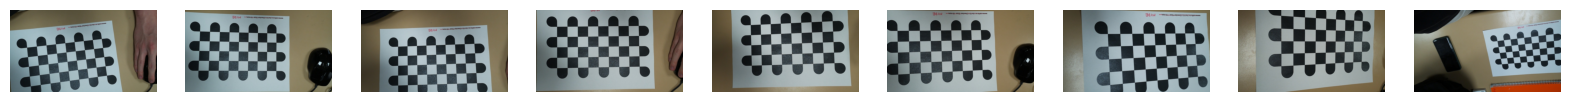

In [6]:
# Show images
plt.figure(figsize=(20, 20))
for i, img in enumerate(imgs):
    plt.subplot(1, len(imgs), i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

The function ``cv2.findChessboardCorners`` of
OpenCV function finds the calibration template in an image and
returns a tuple of two elements. The first element
is 0 if it failed to successfully detect the template, and
is 1 otherwise. The second element contains the
coordinates of the corners of the calibration template,
which are only valid if the detection was successful, 
i.e. if the first element of the tuple is 1.

<hr>

**Use the function** ``cv2.findChessboardCorners``**, and optionally** ``cv2.cornerSubPix``**, to automatically detect the calibration pattern and its corners in all loaded images**. The size of the calibration stencil in the practice images is (8, 6), that is, 8 rows and 6 columns. It stores the results of the multiple calls in a list, so that the element $i$ in that list corresponds to the result of ``cv2.findChessboardCorners`` for the image $i$ loaded earlier.

In [7]:
# We will execute findChessboardCorners for each image to find the corners
dim = (9, 5)
corners = [cv2.findChessboardCorners(i, dim) for i in imgs]

In [8]:
# OPTIONAL => cornerSubPix is a destructive function. so we need to copy corners to avoid data loss
corners2 = copy.deepcopy(corners)

# termination criteria (https://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)
# Cada una de las imagenes la volvemos a blanco y negro
imgs_grey = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in imgs]
# For each image and corners we are going to use cornerSubPix
cornersRefined = [cv2.cornerSubPix(i, cor[1], dim, (-1, -1), criteria) if cor[0] else [] for i, cor in zip(imgs_grey, corners2)]
# pp(cornersRefined)

The next exercise consists of drawing on the images the points detected by ``cv.FindChessboardCorners``. For efficiency reasons, the function used to do this modifies directly the images passed by parameter instead of making a copy. To avoid losing the original images it is better to make a copy of them in advance. One way to do this is ``imgs2 = copy.deepcopy(imgs)``
where ``imgs`` is the list of loaded images. Use these copied images instead of the original ones in the
in the following exercise.

<hr>

**Use.**  ``cv2.drawChessboardCorners`` **to draw the corners detected in the previous exercise**. Apply it to all images that were correctly detected. Ignore the rest.

Display some results

In [9]:
# OPTIONAL => drawChessboardCorners is a destructive function. so we need to copy corners to avoid data loss
imgs2 = copy.deepcopy(imgs)

# We are going to draw the corners if we have found them
tmp = [cv2.drawChessboardCorners(img, dim, cor[1], cor[0]) for img, cor in zip(imgs2, corners) if cor[0]]

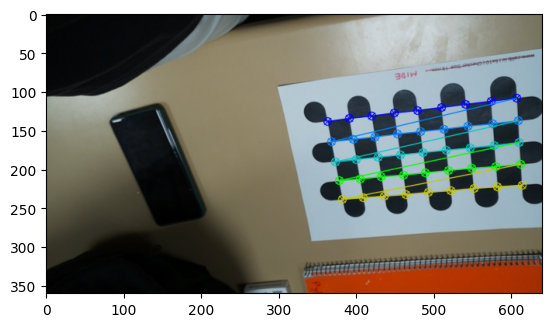

In [10]:
# Original Image
plt.figure()
plt.imshow(imgs2[-1])

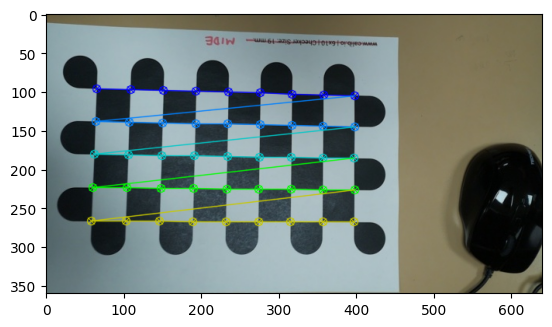

In [11]:
# Image with the corners drawed
plt.figure()
plt.imshow(imgs2[1])

To calibrate the camera, in addition to the coordinates of the corners in each of the images, the three-dimensional corner coordinates of the corners in the reference system of the scene.
 For this practice we will consider that the center of the reference system, i.e. the
point of coordinates $[0, 0, 0]^\top$, is the first corner of the calibration template detected in the scene's reference frame.
We will also consider that the X-axis corresponds to the short side of the calibration template, i.e., the coordinate point, and the Y-axis to the long side.
This arrangement implies that the Z-axis points in the upward normal direction of the calibration plane.


For the following exercise it is very important to take into account that the coordinates of the corners in the system of
scene reference should be given in the same order as
in which they were detected in each of the images.

<hr>

**Implement the function** ``get_chessboard_points (chessboard_shape, dx, dy)`` that will generate an array of `NumPy` (that is, an ndarray) of
size $ N × 3 $ with the coordinates $ (x, y, z) $ of the corners of
the calibration template in the reference system of the
scene. $ N $ is the number of corners in the template.

``chessboard_shape`` is the number of points per row
and by columns of the calibration template. Like
in Exercise 1, it should be (8, 6). `` dx`` (resp. `` dy``) is the width
(resp. high) of a square of the calibration template.
For the template used in this lab, both values
they are $30mm$.

In [12]:
def get_chessboard_points(chessboard_shape, dx, dy):
    return [[(i%chessboard_shape[0])*dx, (i//chessboard_shape[0])*dy, 0] for i in range(np.prod(chessboard_shape))]

cb_points = get_chessboard_points(dim, 21, 21)
# pp(cb_points)

<hr>

**ASIGNMENT** Repeat the procedure to calibrate the right camera too. In the end, print the calculated extrinsics and intrinsics parameters for both cameras.

Once finished, **please print the root mean square reprojection error and justify in the report its meaning.**

In [13]:
# We are going to retrieve existing corners (cor[0] == True)
valid_corners = [cor[1] for cor in corners if cor[0]]

num_valid_images = len(valid_corners)

# Matrix with the coordinates of the corners
real_points = get_chessboard_points(dim, 21, 21)

# We are going to convert our coordinates list in the reference system to numpy array
object_points = np.asarray([real_points for i in range(num_valid_images)], dtype=np.float32)

# Convert the corners list to array
image_points = np.asarray(valid_corners, dtype=np.float32)

# Calibrate
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, imgs[1].shape[0:2], None, None)
# Calculate extrinsecs matrix using Rodigues on each rotation vector addid its translation vector
extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))
# Save the calibration file
np.savez('Proyecto_final_vision/calib_params', intrinsic=intrinsics, extrinsic=extrinsics)

# Lets print some outputs
print("Corners standard intrinsics:\n",intrinsics)
print("Corners standard dist_coefs:\n", dist_coeffs)
print("root mean sqaure reprojection error:\n", rms)


Corners standard intrinsics:
 [[665.69165109   0.         336.77063319]
 [  0.         664.35002249 175.2785755 ]
 [  0.           0.           1.        ]]
Corners standard dist_coefs:
 [[-0.03683644  0.05453499  0.00499431  0.00302783  0.29313295]]
root mean sqaure reprojection error:
 0.9690944692467133
